# Coordinate reference system management

In this chapter, we focus on understanding how the coordinate reference system (CRS) can be managed with raster data using `rioxarray` library. As we discussed in Chapter 5.3, the process of attaching information about a location to a piece of information is commonly referred as *{term}`georeferencing`*. When considering raster data, there are ultimately two relevant parts to the georeferencing of a raster dataset: 

1. the definition of the local, regional, or global system in which a raster’s pixels are located (CRS), and
2. the parameters by which pixel coordinates are transformed into coordinates in that system.

In the following, we will focus on inspecting different kinds of georeferencing metadata that are supported by `rioxarray`/`rasterio`, as well as learn how to reproject a raster from one coordinate reference system to another which is a commonly needed GIS technique when doing geographic data analysis. 

## Georeferencing raster data - Key concepts

As we have seen from the previous chapters, raster data represents spatial information as a grid of pixels, commonly used for satellite imagery, elevation models, and land cover maps. However, for a raster to be meaningful in a geographic context, it must be correctly georeferenced. Georeferencing ensures that each pixel corresponds to a specific location on Earth. There are a few central concepts related to georeferencing raster data: the *{term}`coordinate reference system` (CRS)*, the *{term}`transform`* and the *{term}`affine`*. Understanding these concepts is crucial for working with spatial data, as they define how a raster aligns with real-world locations.

- The ***CRS*** defines the spatial reference of the raster, specifying how coordinates are measured. It includes a datum (e.g. WGS84) and a projection (e.g. UTM) that determine how the Earth's curved surface is represented in a flat raster dataset. Without a CRS, a raster lacks geographic context.
- The ***transform*** describes how pixel coordinates (row, column) map to real-world coordinates (e.g., meters or degrees). It defines the raster’s scale, rotation, and location.
- The ***affine*** transformation is a mathematical model commonly used in Python to define the spatial transformation of raster data. It consists of six parameters that control translation (position), scaling (resolution), and rotation/skew. 


In addition to these concepts, a raster dataset may also be georeferenced using *{term}`Ground Control Points` (GCP)* or *{term}`Rational Polynomial Coefficients` (RPCs)*. Ground Control Points are known locations on the Earth's surface with accurately measured coordinates using e.g. GPS device or derived from high-resolution reference image. They are used to improve georeferencing accuracy by linking raster pixel positions to real-world coordinates. GCPs help correct distortions in aerial or satellite images by creating polynomial transformations. Typically a dataset will have multiple GCPs distributed across the image. 

Rational Polynomial Coefficients (RPCs) provide an alternative georeferencing method, often used for high-resolution satellite imagery. Instead of an affine transform, RPCs model the relationship between image coordinates and real-world coordinates using rational polynomial coefficients which are typically provided by satellite image providers. They allow for more complex transformations, especially in cases where elevation variations affect image positioning. 

## Accessing metadata about coordinate reference system

Now as we know some basics about the georeferensing raster data, let's start and investigate how the coordinate reference system information is stored in `xarray` / `rioxarray`. Let's start by reading a raster dataset that we have also used in previous chapters:

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

fp = "data/temp/kilimanjaro_dataset.nc"

data = xr.open_dataset(fp, decode_coords="all")
data

<xarray.Dataset> Size: 156MB
Dimensions:          (y: 3601, x: 3601)
Coordinates:
  * x                (x) float64 29kB 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0
  * y                (y) float64 29kB -2.0 -2.0 -2.001 ... -2.999 -3.0 -3.0
    spatial_ref      int32 4B ...
Data variables:
    elevation        (y, x) float64 104MB ...
    relative_height  (y, x) float32 52MB ...

As was already briefly shown in Chapter 7.2, we can call the `.rio.crs` to access the Coordinate Reference System information attached to our raster dataset:

In [43]:
data.rio.crs

CRS.from_epsg(4326)

In [44]:
type(data.rio.crs)

rasterio.crs.CRS

As we can see, the `.rio.crs` returns some basic information about the coordinate reference system, and in our case, reports that the EPSG code of the dataset is `4326` (i.e. WGS84). When checking the type of the object we can see that the `rio.crs` it is actually a `CRS` class object from `rasterio` library that contains some helpful functionalities related to working with CRS. For instance, if you want to extract the EPSG-code as a number, you can call the `.to_epsg()` method: 

In [4]:
data.rio.crs.to_epsg()

4326

In addition, in casse you are interested to investigate the CRS information in Well-Known Text (WKT) format, it is easy to parse this information using the `.to_wkt()` method:

In [48]:
data.rio.crs.to_wkt()

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

There are also various other useful functionalities that you can explore via the `.crs` accessor, such as:

- `.is_geographic` which returns `True` if the data is in geographic CRS (`False` otherwise)
- `.is_projected` which returns `True` if the data is in projected CRS, e.g. UTM (`False` otherwise)
- `.units_factor` which returns information about the units of the coordinates (degree or meter)

Another place to find relevant information about the coordinate reference system is to look at the contents of the `spatial_ref` attribute in the `xarray.Dataset`. We can access various key attributes of the CRS by calling `.spatial_ref.attrs` that prints a Python `dictionary` containing the information:

In [63]:
data.spatial_ref.attrs

{'crs_wkt': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]',
 'semi_major_axis': 6378137.0,
 'semi_minor_axis': 6356752.314245179,
 'inverse_flattening': 298.257223563,
 'reference_ellipsoid_name': 'WGS 84',
 'longitude_of_prime_meridian': 0.0,
 'prime_meridian_name': 'Greenwich',
 'geographic_crs_name': 'WGS 84',
 'horizontal_datum_name': 'World Geodetic System 1984',
 'grid_mapping_name': 'latitude_longitude',
 'spatial_ref': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]',
 'Geo

To find out the names of the CRS related attributes, you can access the `.key()` of the dictionary which returns a collection of keys available in the `spatial_ref`:

In [64]:
data.spatial_ref.attrs.keys()

dict_keys(['crs_wkt', 'semi_major_axis', 'semi_minor_axis', 'inverse_flattening', 'reference_ellipsoid_name', 'longitude_of_prime_meridian', 'prime_meridian_name', 'geographic_crs_name', 'horizontal_datum_name', 'grid_mapping_name', 'spatial_ref', 'GeoTransform'])

To access individual items from the spatial reference attributes, we can do following:

In [65]:
print(data.spatial_ref.attrs["reference_ellipsoid_name"])
print(data.spatial_ref.attrs["grid_mapping_name"])

WGS 84
latitude_longitude


## Accessing information about affine transformation

As mentioned in the introduction of this chapter, the `transform` of raster data provides information how the raster is scaled, rotated, and located. The `affine` transformation then again converts this information into a mathematical model that is used by the Python tools to conduct coordinate transformations etc. To access this information, we can call the `.rio.transform()` method which returns relevant data about the transform as an `Affine` object:

In [66]:
affine = data.rio.transform()
affine

Affine(0.0002777777777777778, 0.0, 35.9998611111111,
       0.0, -0.0002777777777777781, -1.99986111111111)

The result here contains six different parameters telling about the scale, rotation and location of the raster data. We can also access these parameters individually. To parse information about the pixel size of our raster dataset, we can access the `.a` and `.e` attributes of the affine:

In [67]:
# Pixel size
print("Pixel size x-direction (a):", affine.a)
print("Pixel size y-direction (e):", affine.e)

Pixel size x-direction (a): 0.0002777777777777778
Pixel size y-direction (e): -0.0002777777777777781


As we can see, the pixel size is approximately 0.00028 Decimal degrees to both directions. The scale in y-direction is often reported with negative sign which is normal (as raster images are often stored top-down). 

To find out whether our data is rotated or skewed to specific direction, we can access the attributes `.b` and `.d`:

In [8]:
# Rotation/skew
print("Rotation/skew x-direction (b):", affine.b)
print("Rotation/skew y-direction (d):", affine.d)

Rotation/skew x-direction (b): 0.0
Rotation/skew y-direction (d): 0.0


These return the row and column rotation or skew, which is usually 0 for rasters facing north-up. Finally, we can find the location of our raster by accessing the attributes `.c` and `.f`:

In [9]:
# Top-left corner's real-world coordinates
print("X-coordinate of the top-left pixel (c):", affine.c)
print("Y-coordinate of the top-left pixel (f):", affine.f)

X-coordinate of the top-left pixel (c): 35.9998611111111
Y-coordinate of the top-left pixel (f): -1.99986111111111


The `.c` informs about the location of the X-coordinate of the top-left corner of the raster (a given pixel on that location), while `.f` informs about the Y-coordinate of the same pixel. This is ultimately the location of the pixel that is present at index `[0, 0]` of the 2D array.

## Estimating the UTM zone of a raster

As we saw previously, our `Dataset` currently has a `WGS84` coordinate reference system (EPSG:4326) in which the coordinates are represented as decimal degrees. For various reasons, you might want to reproject your data into a metric CRS, such as national coordinate reference frames (e.g. EUREF-FIN in Finland) or Universal Transverse Mercator (UTM) coordinate system which divides the Earth into 60 zones and projects each one to a plane (Figure 7.20). Most zones in UTM span 6 degrees of longitude, and each has a designated central meridian. UTM zones are widely used in (geographically) large countries, such as in United States and Canada to represent geographic data in a metric coordinate reference system. 

![_**Figure 7.20.** Universal Transverse Mercator (UTM) zones on an equirectangular world map with irregular zones labeled in red. Image source: cmglee, STyx, Wikialine and Goran tek-en (2019) via Wikimedia Commons, licensed under Creative Commons BY-SA 4.0._](../img/UTM_zones.png)

_**Figure 7.20.** Universal Transverse Mercator (UTM) zones on an equirectangular world map with irregular zones labeled in red. Image source: cmglee, STyx, Wikialine and Goran tek-en (2019) via Wikimedia Commons, licensed under Creative Commons BY-SA 4.0._

It is relatively common to use UTM coordinate reference system especially when working with raster data that covers large areas on a sub-national level. However, many datasets are typically distributed in WGS84, which means that you need to know the UTM zone for a given area that covers the raster dataset before you can reproject the data into metric system. Luckily, `rioxarray` includes a handy method called `.rio.estimate_utm_crs()` that makes it possible to make a sophisticated guess of the UTM-zone that the data falls under. In the following, we will find out the UTM-zone for our raster dataset located in Tanzania:

In [10]:
utm_crs = data.rio.estimate_utm_crs()
utm_crs

CRS.from_epsg(32737)

In [11]:
utm_crs.to_wkt()

'PROJCS["WGS 84 / UTM zone 37S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",39],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32737"]]'

As we can see, the EPSG-code for our dataset is `32737` which belongs to UTM zone 37S which is correctly identified. Notice that if your data covers large areas that span across multiple UTM zones, it might not be possible to identify the UTM zone for such data. 

## Reprojecting raster data

Transforming (i.e. reprojecting) a dataset from one CRS to another can be done easily using the `.rio.reproject()` method. The reprojection can be done in various different ways, but one of the most common way to reproject a dataset to given destination CRS is to use the `dst_crs` parameter that accepts the CRS information as EPSG code, OGC WKT string or Proj4 string (see Chapters 5.3 and 6.4 for further details). In the following, we reproject our data from WGS84 into UTM zone 37S by providing the EPSG code as input, as follows:

In [20]:
data_utm = data.rio.reproject(dst_crs="EPSG:32737")

In [33]:
# Alternatively, you can use the estimated UTM zone directly as input
data_utm2 = data.rio.reproject(data.rio.estimate_utm_crs())

Now our data has been successfully reprojected into `EPSG:32737` which means that the coordinates originally represented in decimal degrees were transformed into meters. Let's investigate the coordinates of our reprojected `Dataset` and compare those against the original coordinates:

In [29]:
print("Reprojected X-coordinates:")
print(data_utm.x.values)

print("\nReprojected Y-coordinates:")
print(data_utm.y.values)

Reprojected X-coordinates:
[166223.82358432 166254.64532761 166285.46707089 ... 277644.42556093
 277675.24730422 277706.0690475 ]

Reprojected Y-coordinates:
[9778803.43019196 9778772.60844868 9778741.78670539 ... 9667999.26308106
 9667968.44133778 9667937.61959449]


In [30]:
print("Original X-coordinates:")
print(data.x.values)

print("\nOriginal Y-coordinates:")
print(data.y.values)

Original X-coordinates:
[36.         36.00027778 36.00055556 ... 36.99944444 36.99972222
 37.        ]

Original Y-coordinates:
[-2.         -2.00027778 -2.00055556 ... -2.99944444 -2.99972222
 -3.        ]


As we can see, the coordinates contain now much larger numbers compared to the original x- and y-coordinates represented as decimal degrees. This is expected because the coordinates are based on a false easting and northing in which the easting (X coordinate) represents the distance in meters from the central meridian of the given UTM zone while the northing (Y coordinate) is distance from the equator in meters. To avoid dealing with negative numbers, a false easting of 500,000 meters is added to the central meridian. Thus a point that has an easting of 400000 meters is about 100 km west of the central meridian.

Let's continue and compare the shape of our reprojected raster to the original one:

In [32]:
print("Shape of the reprojected raster:")
data_utm.rio.shape

Shape of the reprojected raster:


(3598, 3618)

In [31]:
print("Shape of the original raster:")
data.rio.shape

Shape of the original raster:


(3601, 3601)

Wait. What?! As we can see, the shape of the raster has changed during the CRS transformation. This might seem weird, but it is actually quite expected. When you reproject raster data to a new coordinate reference system, like transforming from geographic WGS84 coordinate reference system to metric UTM zone 37S, a few things happen that can change the shape and size of the output raster. WGS84 is a geographic CRS that uses degrees, while UTM is a projected CRS in meters. When we transform to UTM, the curved surface of the Earth gets flattened, causing slight distortions. The grid cells, originally evenly spaced in degrees, now stretch and warp in the UTM projection, that can change the dimensions. In addition, the bounding box (extent) of the output raster might shift or expand. When projecting, `rioxarray` needs to make sure that the grid is properly aligned, so it adjusts the pixel grid to fit the new projection that aims to prevent data loss. These processes are reasons why `rioxarray` might add or remove rows/columns to preserve proper alignment when reprojecting data.

Let's finally plot our reprojected data to see that the output looks similar to the original data:

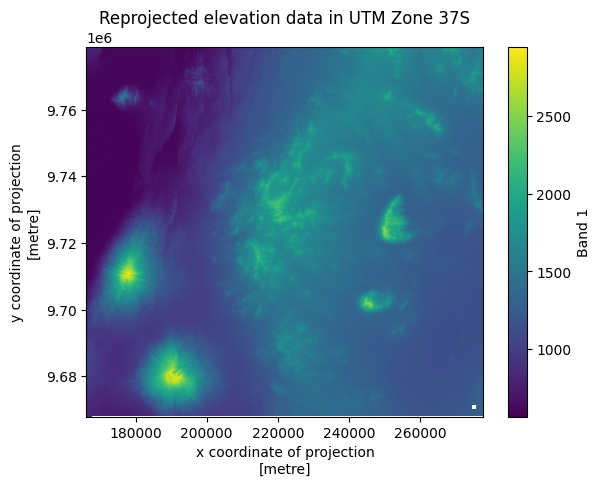

In [36]:
data_utm["elevation"].plot()
plt.title("Reprojected elevation data in UTM Zone 37S");

_**Figure 7.21.** Reprojected raster data in which the coordinates are represented in meters._